In [1]:
import random 
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import xgboost

In [2]:
train = pd.read_csv("/home/thenielfarias/train.csv")

In [3]:
cm = sns.light_palette("red", as_cmap=True)
train.head(30).style.background_gradient(cmap=cm)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000000,8450,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.000000,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,nan,Attchd,2003.000000,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,nan,nan,nan,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000000,9600,Pave,nan,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.000000,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,nan,nan,nan,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000000,11250,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.000000,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.000000,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,nan,nan,nan,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000000,9550,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.000000,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,nan,nan,nan,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000000,14260,Pave,nan,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.000000,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.000000,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,nan,nan,nan,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000000,14115,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Mitchel,Norm,Norm,1Fam,1.5Fin,5,5,1993,1995,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,Wood,Gd,TA,No,GLQ,732,Unf,0,64,796,GasA,Ex,Y,SBrkr,796,566,0,1362,1,0,1,1,1,1,TA,5,Typ,0,nan,Attchd,1993.000000,Unf,2,480,TA,TA,Y,40,30,0,320,0,0,nan,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000000,10084,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,Somerst,Norm,Norm,1Fam,1Story,8,5,2004,2005,Gable,CompShg,VinylSd,VinylSd,Stone,186.000000,Gd,TA,PConc,Ex,TA,Av,GLQ,1369,Unf,0,317,1686,GasA,Ex,Y,SBrkr,1694,0,0,1694,1,0,2,0,3,1,Gd,7,Typ,1,Gd,Attchd,2004.000000,RFn,2,636,TA,TA,Y,255,57,0,0,0,0,nan,nan,nan,0,8,2007,WD,Normal,307000
7,8,60,RL,nan,10382,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,NWAmes,PosN,Norm,1Fam,2Story,7,6,1973,1973,Gable,CompShg,HdBoard,HdBoard,Stone,240.000000,TA,TA,CBlock,Gd,TA,Mn,ALQ,859,BLQ,32,216,1107,GasA,Ex,Y,SBrkr,1107,983,0,2090,1,0,2,1,3,1,TA,7,Typ,2,TA,Attchd,1973.000000,RFn,2,484,TA,TA,Y,235,204,228,0,0,0,nan,nan,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000000,6120,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,OldTown,Artery,Norm,1Fam,1.5Fin,7,5,1931,1950,Gable,CompShg,BrkFace,Wd Shng,None,0.000000,TA,TA,BrkTil,TA,TA,No,Unf,0,Unf,0,952,952,GasA,Gd,Y,FuseF,1022,752,0,1774,0,0,2,0,2,2,TA,8,Min1,2,TA,Detchd,1931.000000,Unf,2,468,Fa,TA,Y,90,0,205,0,0,0,nan,nan,nan,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000000,7420,Pave,nan,Reg,Lvl,AllPub,Corner,Gtl,B

In [4]:
# Columns and data types

pd.DataFrame(train.columns, columns=["name"])

,name
0,Id
1,MSSubClass
2,MSZoning
3,LotFrontage
4,LotArea
...,...
76,MoSold
77,YrSold
78,SaleType
79,SaleCondition


In [5]:
pd.DataFrame(train.dtypes, columns=["type"])

,type
Id,int64
MSSubClass,int64
MSZoning,object
LotFrontage,float64
LotArea,int64
...,...
MoSold,int64
YrSold,int64
SaleType,object
SaleCondition,object


In [6]:
train.loc[:, train.columns != 'Id'].describe().style.background_gradient(cmap=cm)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [7]:
train.loc[:, train.columns=='SalePrice'].describe().style.background_gradient(cmap=cm)

,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


In [8]:
def get_random_color():
    r1 = lambda: random.randint(0,255)
    return '#%02X%02X%02X' % (r1(),r1(),r1())

def get_histplot_central_tendency(df: dict, fields: list):
    for field in fields:
        f, (ax1) = plt.subplots(1, 1, figsize=(15, 5))
        v_dist_1 = df[field].values
        sns.histplot(v_dist_1, ax=ax1, color=get_random_color(), kde=True)

        mean = df[field].mean()
        median = df[field].median()
        mode = df[field].mode().values[0]

        ax1.axvline(mean, color='r', linestyle='--', label="Mean")
        ax1.axvline(median, color='g', linestyle='-', label="Mean")
        ax1.axvline(mode, color='b', linestyle='-', label="Mode")
        ax1.legend()

        plt.title(f"{field} - Histogram")

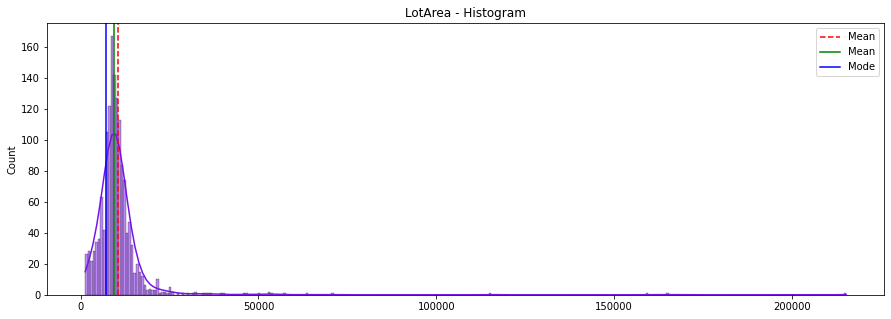

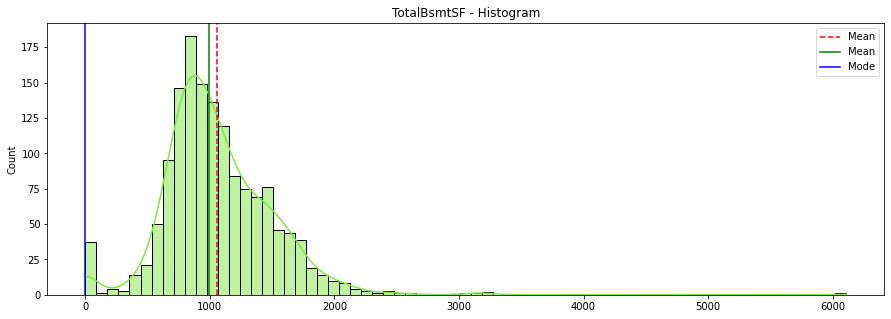

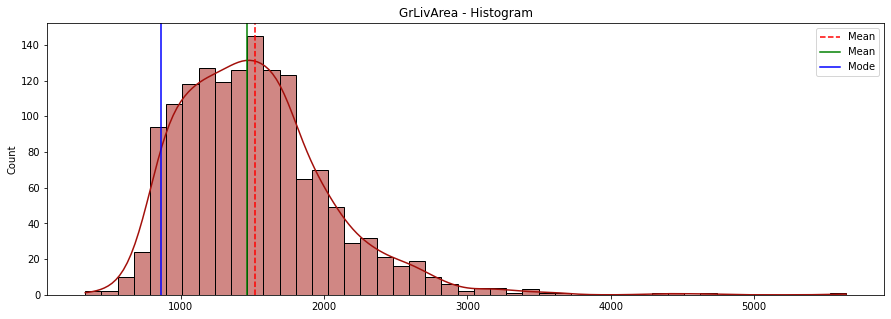

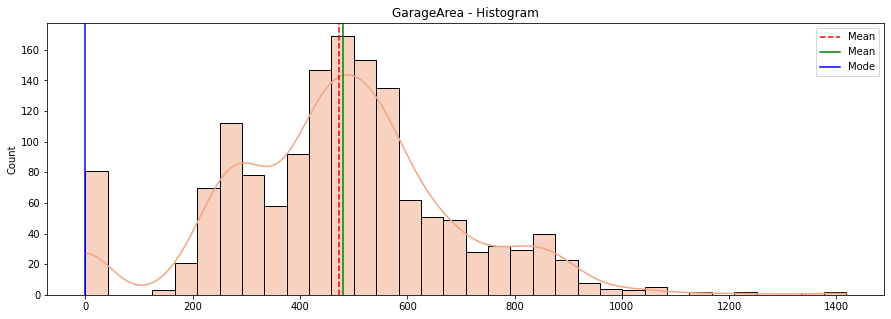

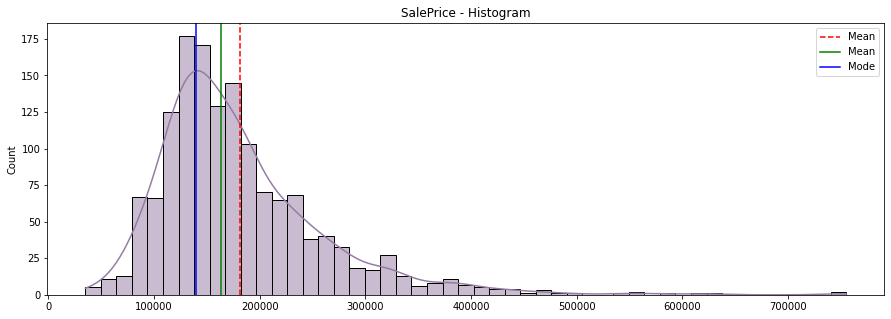

In [9]:
# Histogram analysis

fields = ["LotArea", "TotalBsmtSF", "GrLivArea", "GarageArea", "SalePrice"]
get_histplot_central_tendency(train, fields)

In [10]:
def get_scatter(df: dict, fields: list):
    ylim = (0, 700000)
    for field in fields:
        df_copy = pd.concat([df['SalePrice'], df[field]], axis=1)
        df_copy.plot.scatter(x=field, y='SalePrice', ylim=ylim, color=get_random_color())
        plt.title(f"{field} - Relationship with SalesPrice")

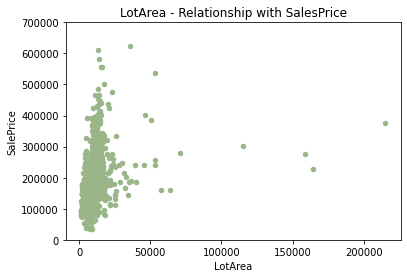

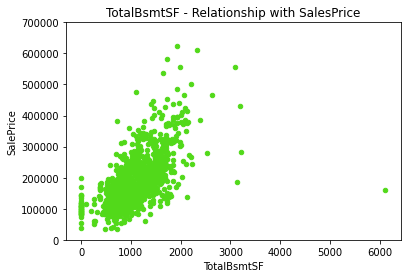

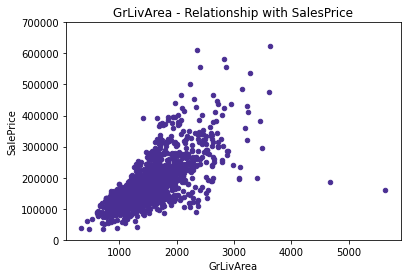

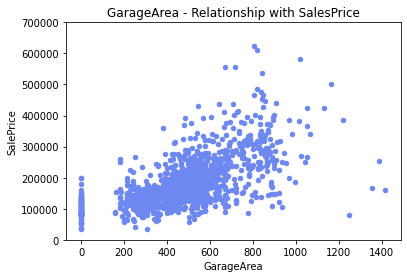

In [11]:
# Scatter analysis 

get_scatter(train, fields[0:4])

In [12]:
def get_headmap_price(df: dict):
    corr = df.corr()
    plt.figure(figsize=(35, 35))
    sns.heatmap(corr, annot=True, cmap="YlOrBr", linewidths=0.1, annot_kws={"fontsize":10})
    plt.title("Correlation house prices")

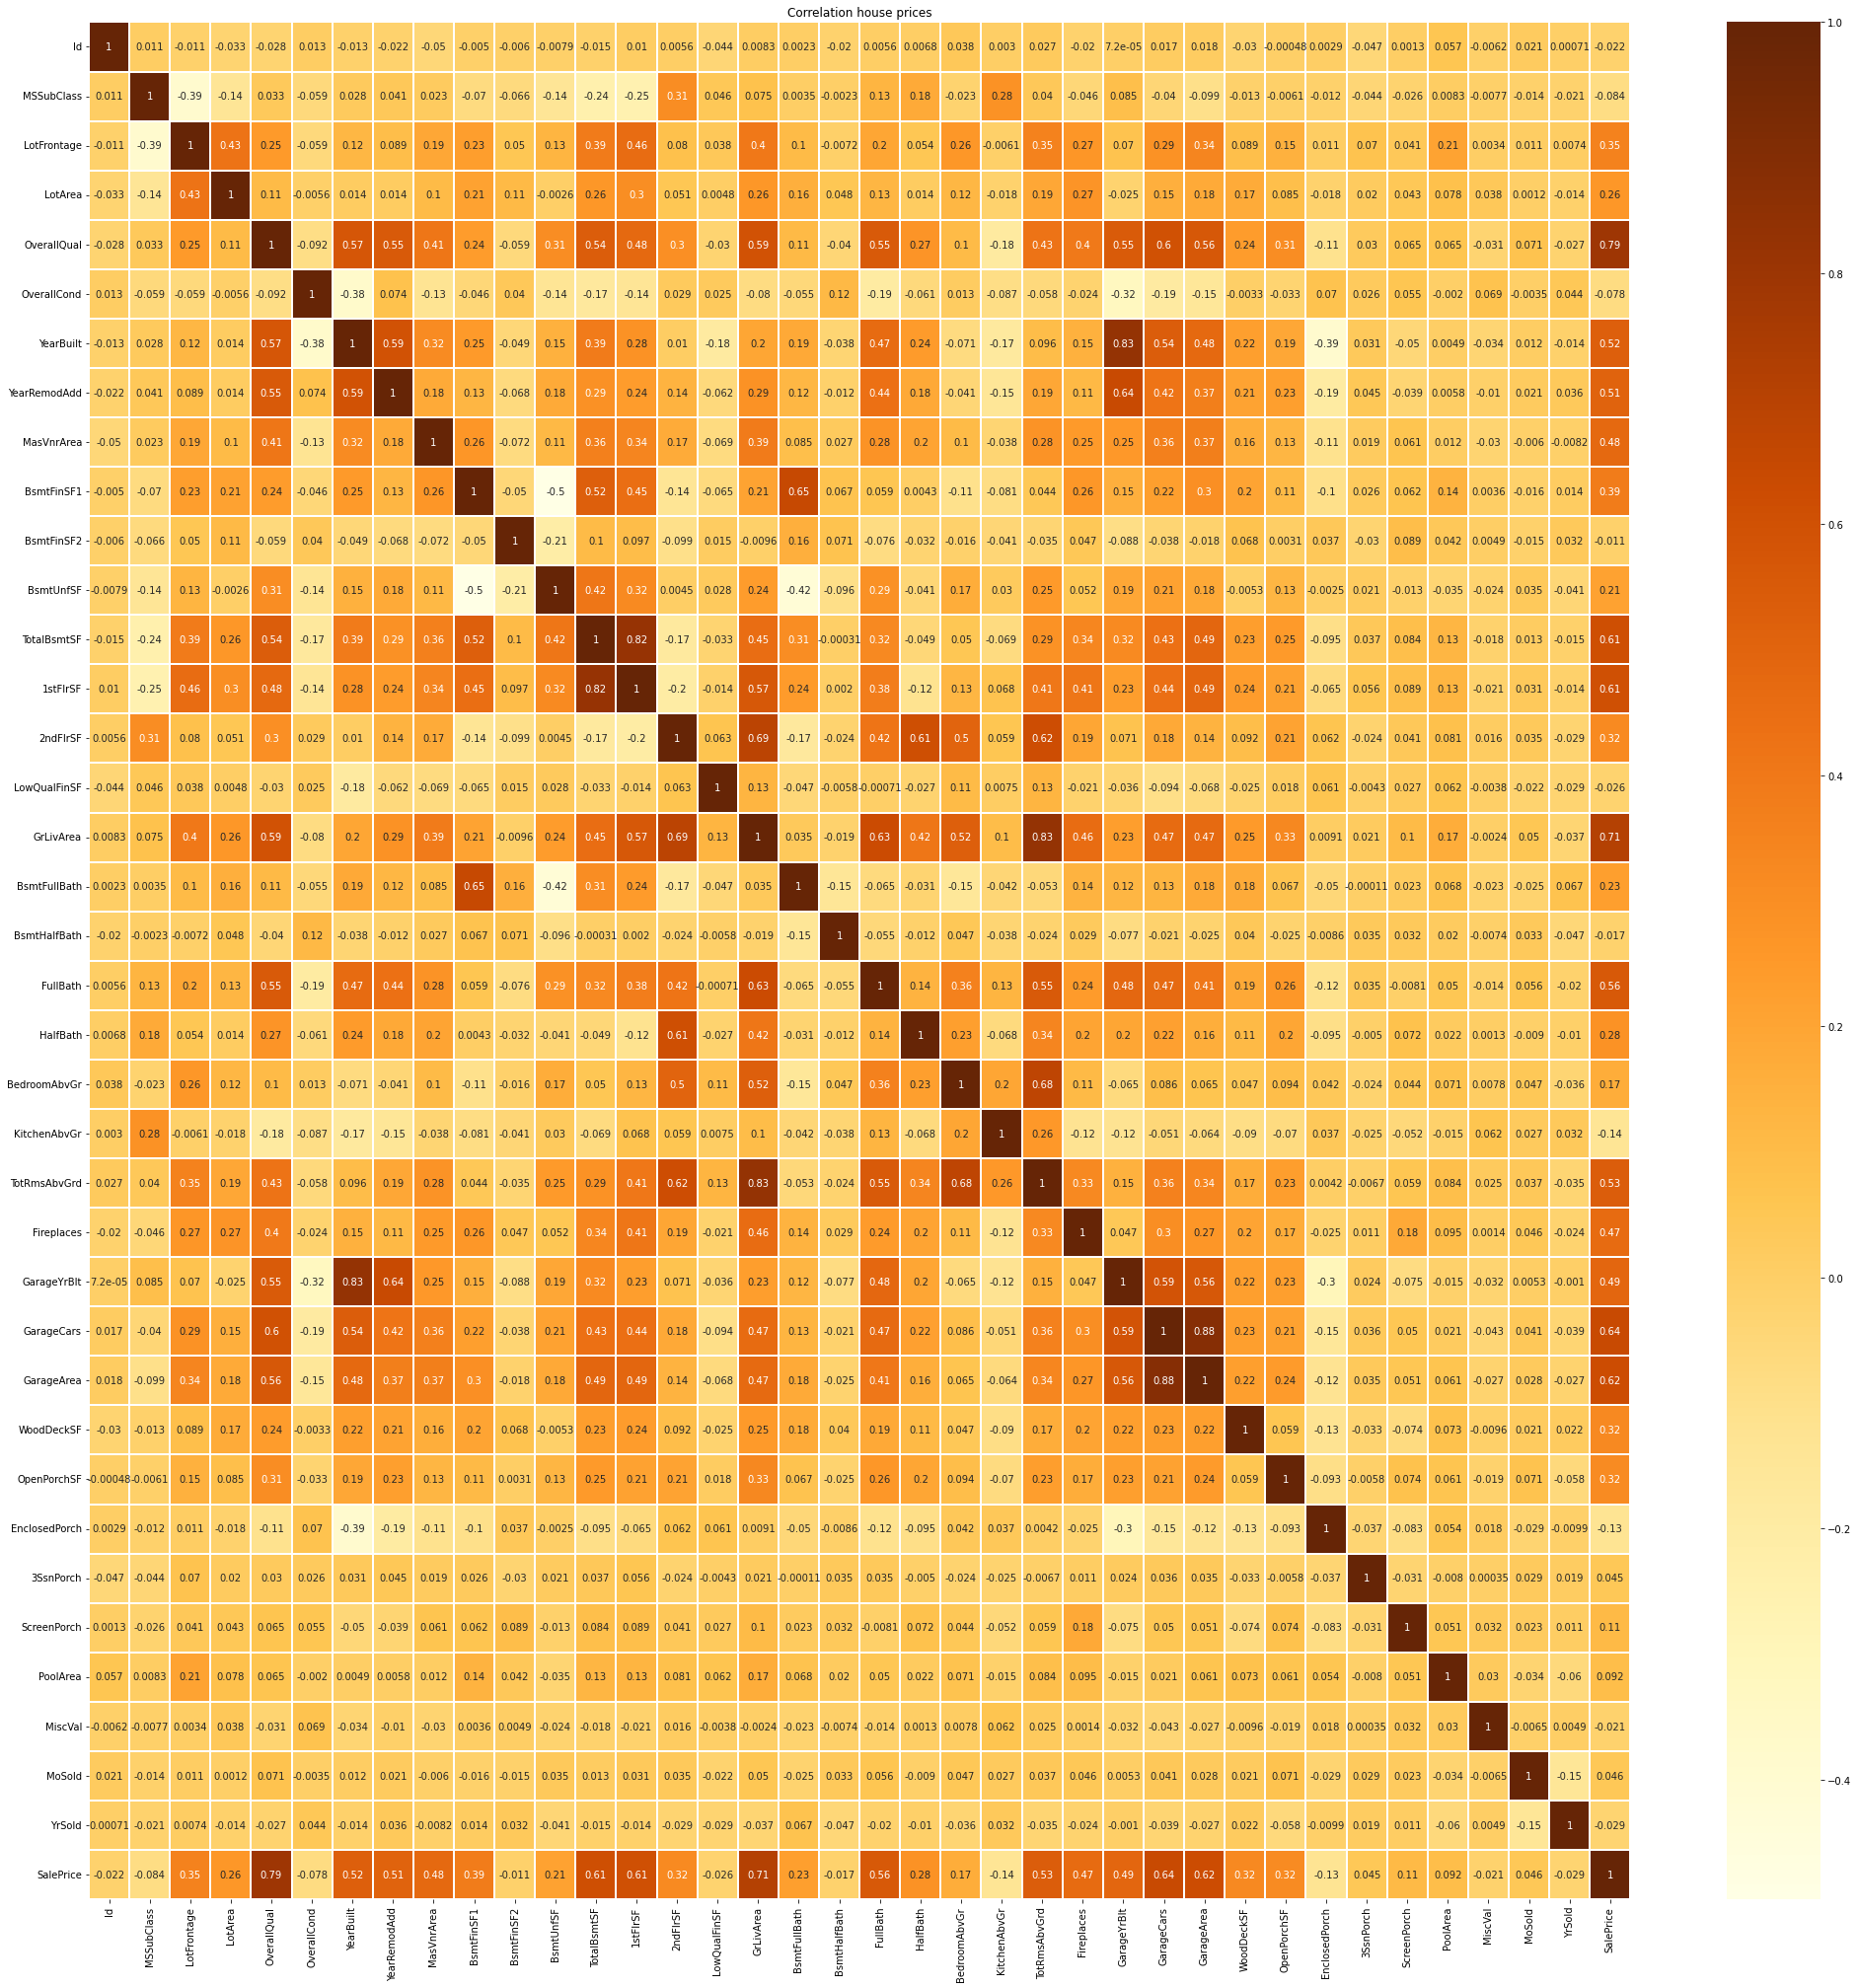

In [13]:
# Correlation heatmap

get_headmap_price(train)

In [14]:
pd.DataFrame(train.isnull().sum().sort_values(ascending=False), columns=["count"]).style.background_gradient(cmap=cm)

,count
PoolQC,1453
MiscFeature,1406
Alley,1369
Fence,1179
FireplaceQu,690
LotFrontage,259
GarageYrBlt,81
GarageCond,81
GarageType,81
GarageFinish,81


In [15]:
def get_boxplot_price(df: dict, fields: list):
    for field in fields:
        data_copy = pd.concat([df['SalePrice'], df[field]], axis=1)
        f, ax = plt.subplots(figsize=(26, 6))
        fig = sns.boxplot(x=field, y="SalePrice", data=data_copy, palette="Set3")
        plt.xticks(rotation=90)
        plt.title(f"Boxplot - {field} x SalePrice")
        plt.show()

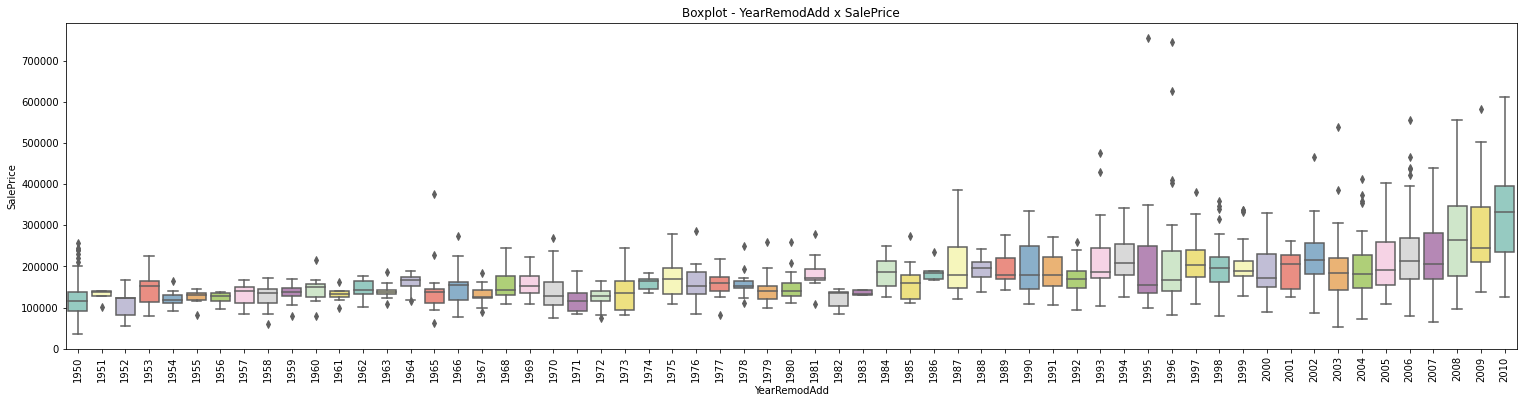

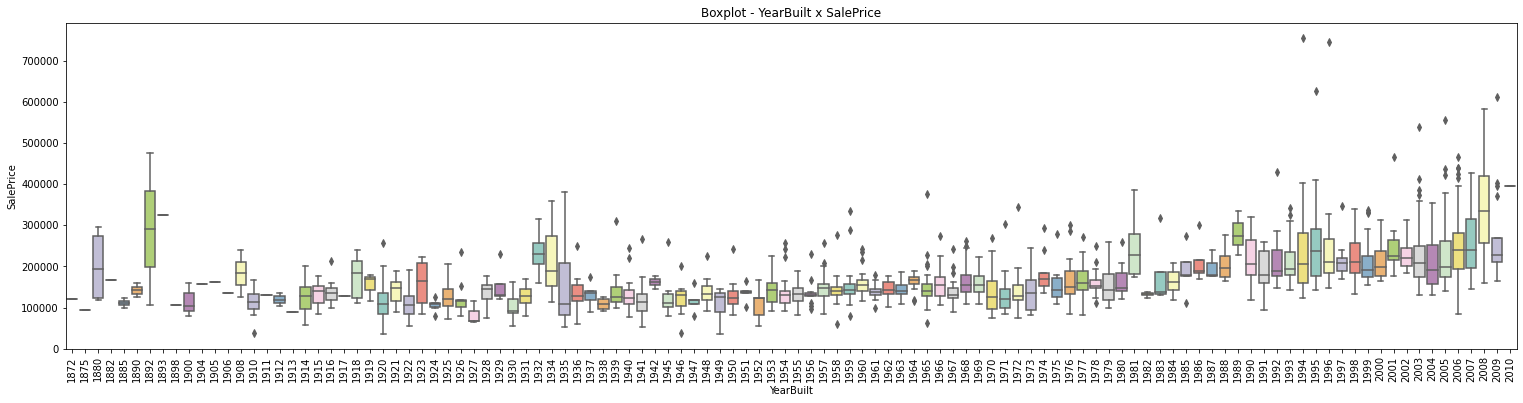

In [16]:
# Boxplots SalesPrice x Year

get_boxplot_price(train, ["YearRemodAdd", "YearBuilt"])

In [17]:
def get_bar_compare(df: dict, fields: list):
    for field in fields:
        plt.figure(figsize=(15, 6))
        sns.barplot(x=field, y='SalePrice', data=df, palette="Set3")
        plt.xlabel(field)
        plt.ylabel('Sale Price')
        plt.show()

In [18]:
# Bar graphs 

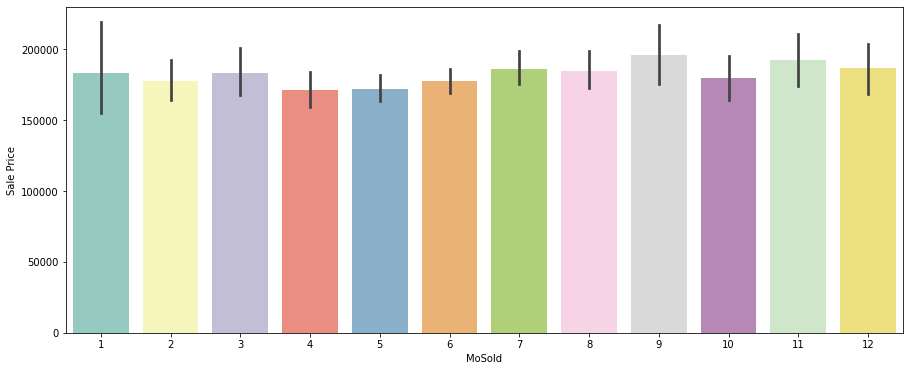

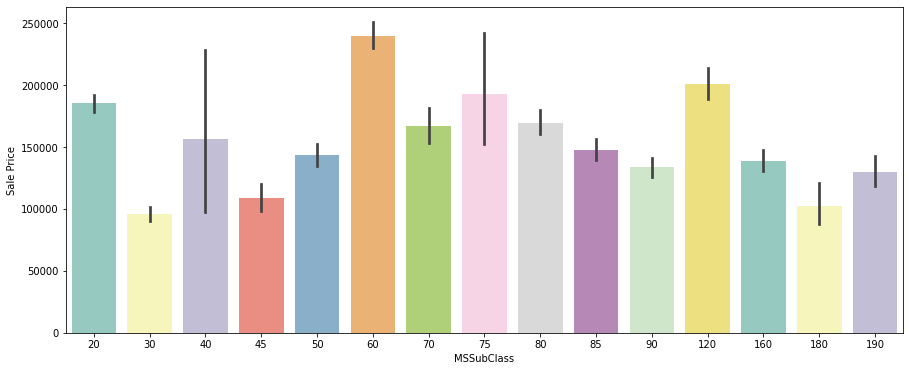

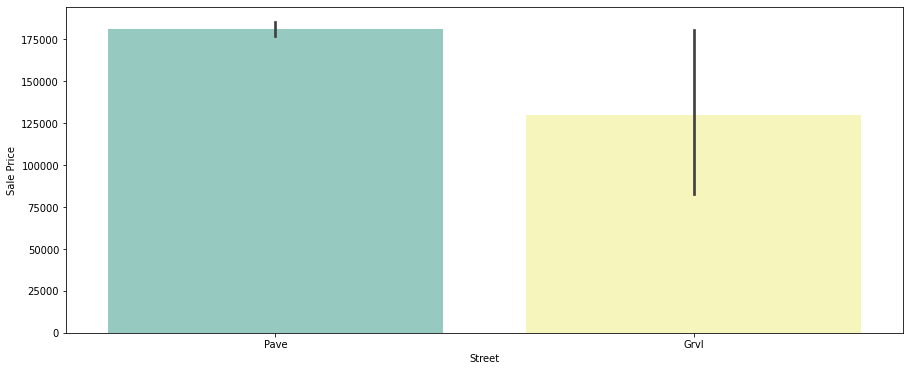

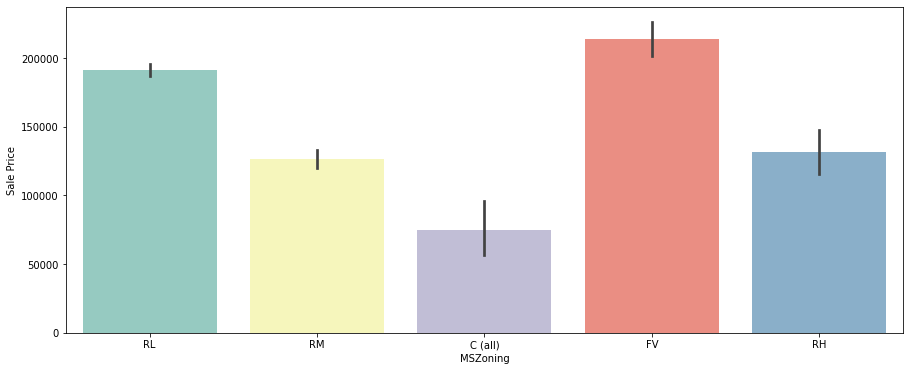

In [19]:
get_bar_compare(train, ["MoSold", "MSSubClass", "Street", "MSZoning"])

In [20]:
# Data cleaning and features analysis

def cleaning_data_none(train: dict, fields: dict):
    for field in fields:
        train[field].fillna('None', inplace=True)
    
def cleaning_data_int(train: dict, fields: dict):
    for field in fields:
        train[field].fillna(0, inplace=True)
        
def cleaning_data_median(train: dict, fields: dict):
    for field in fields:
        train[field].fillna(train[field].median(), inplace=True)

In [21]:
fields_clean_none = ['PoolQC',
                     'Alley',
                     'FireplaceQu',
                     'MasVnrType',
                     'Electrical',
                     'BsmtFinType2',
                     'BsmtFinType1',
                     'BsmtExposure',
                     'BsmtQual',
                     'BsmtCond',
                     'Fence',
                     'MiscFeature',
                     'GarageCond',
                     'GarageQual',
                     'GarageFinish',
                     'GarageType',
                     'SaleType',
                     'Utilities',
                     'Exterior1st',
                     'Exterior2nd',
                     'KitchenQual',
                     'Functional']

fields_clean_int = ['GarageYrBlt', 'MSZoning', 'BsmtFinSF1', 'BsmtFullBath', 'BsmtHalfBath']

fields_clean_median = ['LotFrontage',
                        'MasVnrArea',
                        'BsmtUnfSF',
                        'TotalBsmtSF',
                         'GarageCars',
                         'GarageArea']
                       

cleaning_data_none(train, fields_clean_none)
cleaning_data_int(train, fields_clean_int)
cleaning_data_median(train, fields_clean_median)

In [22]:
features = train.columns
features = list(features[1:len(features)-1])

In [23]:
len(features)

79

In [24]:
# Data encoding and features analysis 

df_types = pd.DataFrame(train.dtypes, columns=["types"])
df_types_object = df_types[df_types["types"] == "object"]

for field_obj in df_types_object.index:
    train[field_obj] = train[field_obj].astype('category').cat.codes

train.head(20).style.background_gradient(cmap=cm)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,3,65.000000,8450,1,1,3,3,0,4,0,5,2,2,0,5,7,5,2003,2003,1,1,12,13,1,196.000000,2,4,2,2,4,3,2,706,6,0,150,856,1,0,1,5,856,854,0,1710,1,0,2,1,3,1,2,8,6,0,3,1,2003.000000,2,2,548,5,5,2,0,61,0,0,0,0,3,4,1,0,2,2008,8,4,208500
1,2,20,3,80.000000,9600,1,1,3,3,0,2,0,24,1,2,0,2,6,8,1976,1976,1,1,8,8,2,0.000000,3,4,1,2,4,1,0,978,6,0,284,1262,1,0,1,5,1262,0,0,1262,0,1,2,0,3,1,3,6,6,1,5,1,1976.000000,2,2,460,5,5,2,298,0,0,0,0,0,3,4,1,0,5,2007,8,4,181500
2,3,60,3,68.000000,11250,1,1,0,3,0,4,0,5,2,2,0,5,7,5,2001,2002,1,1,12,13,1,162.000000,2,4,2,2,4,2,2,486,6,0,434,920,1,0,1,5,920,866,0,1786,1,0,2,1,3,1,2,6,6,1,5,1,2001.000000,2,2,608,5,5,2,0,42,0,0,0,0,3,4,1,0,9,2008,8,4,223500
3,4,70,3,60.000000,9550,1,1,0,3,0,0,0,6,2,2,0,5,7,5,1915,1970,1,1,13,15,2,0.000000,3,4,0,4,1,3,0,216,6,0,540,756,1,2,1,5,961,756,0,1717,1,0,1,0,3,1,2,7,6,1,2,5,1998.000000,3,3,642,5,5,2,0,35,272,0,0,0,3,4,1,0,2,2006,8,0,140000
4,5,60,3,84.000000,14260,1,1,0,3,0,2,0,15,2,2,0,5,8,5,2000,2000,1,1,12,13,1,350.000000,2,4,2,2,4,0,2,655,6,0,490,1145,1,0,1,5,1145,1053,0,2198,1,0,2,1,4,1,2,9,6,1,5,1,2000.000000,2,3,836,5,5,2,192,84,0,0,0,0,3,4,1,0,12,2008,8,4,250000
5,6,50,3,85.000000,14115,1,1,0,3,0,4,0,11,2,2,0,0,5,5,1993,1995,1,1,12,13,2,0.000000,3,4,5,2,4,3,2,732,6,0,64,796,1,0,1,5,796,566,0,1362,1,0,1,1,1,1,3,5,6,0,3,1,1993.000000,3,2,480,5,5,2,40,30,0,320,0,0,3,2,3,700,10,2009,8,4,143000
6,7,20,3,75.000000,10084,1,1,3,3,0,4,0,21,2,2,0,2,8,5,2004,2005,1,1,12,13,3,186.000000,2,4,2,0,4,0,2,1369,6,0,317,1686,1,0,1,5,1694,0,0,1694,1,0,2,0,3,1,2,7,6,1,2,1,2004.000000,2,2,636,5,5,2,255,57,0,0,0,0,3,4,1,0,8,2007,8,4,307000
7,8,60,3,69.000000,10382,1,1,0,3,0,0,0,14,4,2,0,5,7,6,1973,1973,1,1,6,6,3,240.000000,3,4,1,2,4,2,0,859,1,32,216,1107,1,0,1,5,1107,983,0,2090,1,0,2,1,3,1,3,7,6,2,5,1,1973.000000,2,2,484,5,5,2,235,204,228,0,0,0,3,4,3,350,11,2009,8,4,200000
8,9,50,4,51.000000,6120,1,1,3,3,0,4,0,17,0,2,0,0,7,5,1931,1950,1,1,3,15,2,0.000000,3,4,0,4,4,3,6,0,6,0,952,952,1,2,1,1,1022,752,0,1774,0,0,2,0,2,2,3,8,2,2,5,5,1931.000000,3,2,468,1,5,2,90,0,205,0,0,0,3,4,1,0,4,2008,8,0,129900
9,10,190,3,50.000000,7420,1,1,3,3,0,0,0,3,0,0,1,1,5,6,1939,1950,1,1,8,8,2,0.000000,3,4,0,4,4,3,2,851,6,0,140,991,1,0,1,5,1077,0,0,1077,1,0,1,0,2,2,3,5,6,2,5,1,1939.000000,2,1,205,2,5,2,0,4,0,0,0,0,3,4,1,0,1,2008,8,4,118000


In [25]:
# Xgboost regression training

y = train['SalePrice']
X = train[features]

model = xgboost.XGBRegressor(n_estimators=1000, max_depth=10, eta=0.1, subsample=0.7, colsample_bytree=0.8)

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
xgboost_model = model.fit(x_train, y_train)
xgboost_model.score(x_test, y_test)

0.9056294687201136

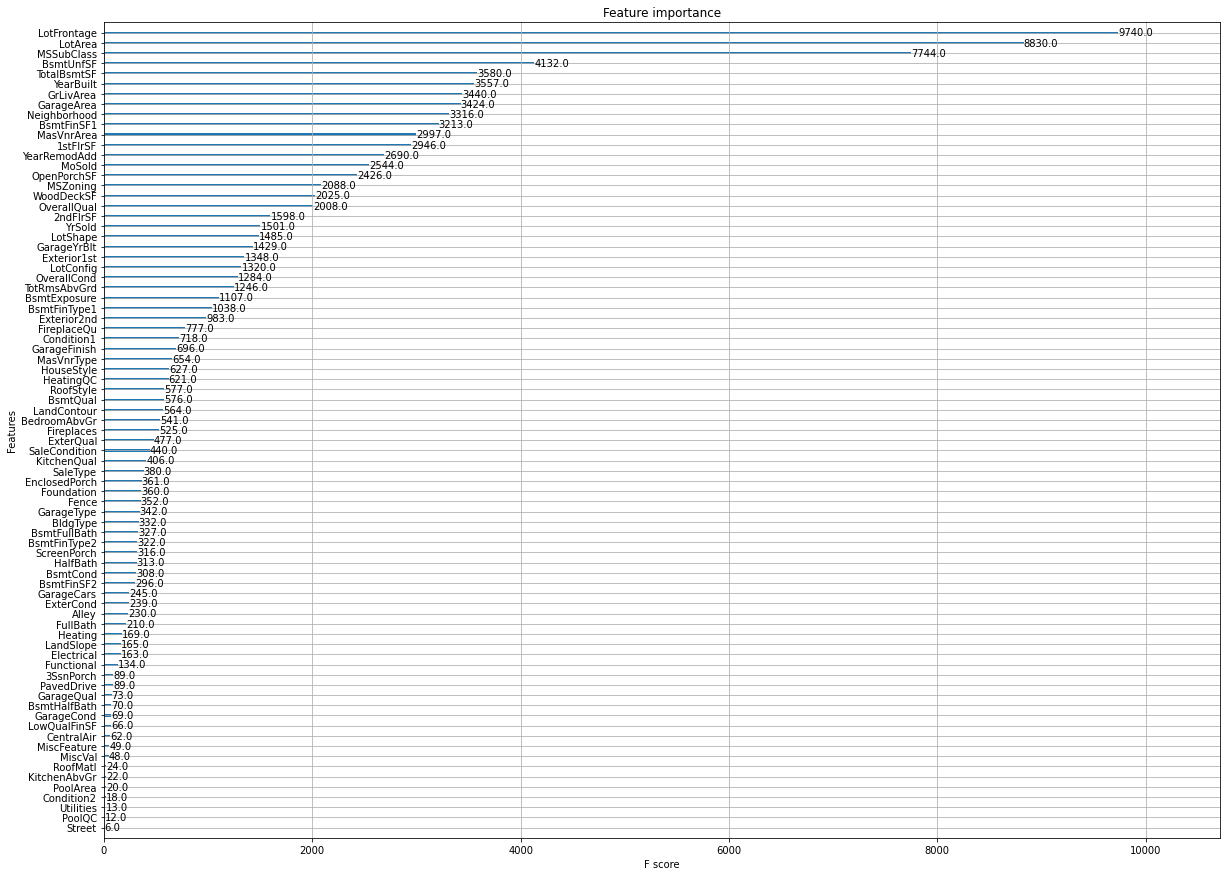

In [26]:
# Features importance

from xgboost import plot_importance

plt.rcParams["figure.figsize"] = (20, 15)
plot_importance(model, max_num_features=100)
plt.show()

In [27]:
# Xgboost model evaluation

def get_plot_predict(y, y_pred):
    plt.figure(figsize=(15, 5))

    ax1 = sns.distplot(y, hist=False, color="blue", label="truth")
    ax2 = sns.distplot(y_pred, hist=False, color="red", label="prediction", ax=ax1)

    plt.title("Truth x Predictions")
    plt.xlabel("SalesPrice")
    plt.gca().legend()
    plt.grid()
    plt.show()

Train set
r2: 1.0
Squared error: 0.06


/home/thenielfarias/.local/share/virtualenvs/thenielfarias-orcZKmpx/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/thenielfarias/.local/share/virtualenvs/thenielfarias-orcZKmpx/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


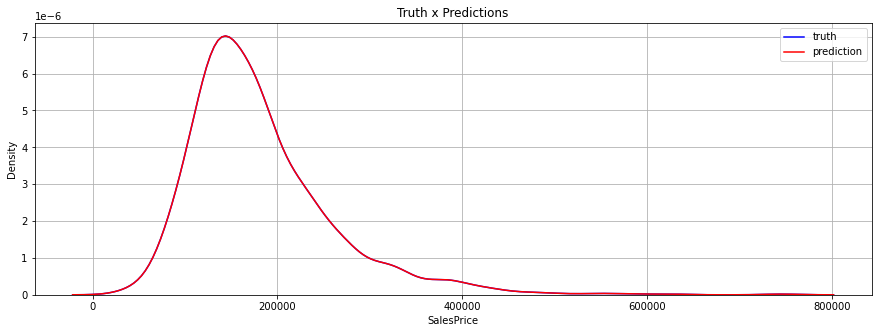

Test set
r2: 0.91
Squared error: 26904.51


/home/thenielfarias/.local/share/virtualenvs/thenielfarias-orcZKmpx/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/home/thenielfarias/.local/share/virtualenvs/thenielfarias-orcZKmpx/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


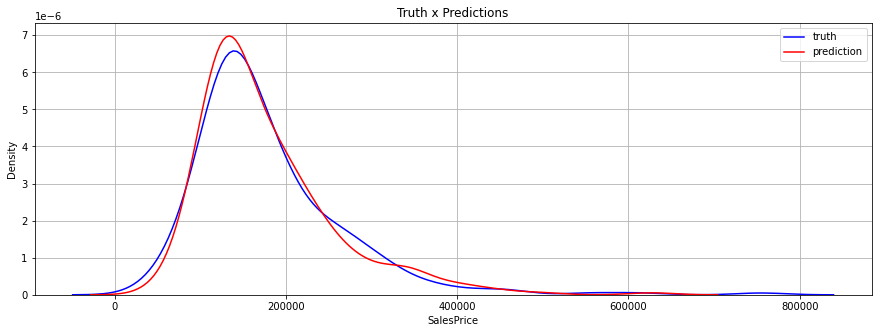

In [28]:
train_predict = xgboost_model.predict(x_train)
test_predict = xgboost_model.predict(x_test)

r2_train = r2_score(y_train, train_predict)
squared_error_train = np.sqrt(mean_squared_error(y_train, train_predict))
                              
r2_test = r2_score(y_test, test_predict)
squared_error_test = np.sqrt(mean_squared_error(y_test, test_predict))
                            
print("Train set")
print(f"r2: {round(r2_train, 2)}")
print(f"Squared error: {round(squared_error_train, 2)}")
get_plot_predict(y_train, train_predict)

print("Test set")
print(f"r2: {round(r2_test, 2)}")
print(f"Squared error: {round(squared_error_test, 2)}")
get_plot_predict(y_test, test_predict)

In [29]:
test = pd.read_csv('/home/thenielfarias/test.csv')

In [30]:
test.head(10).style.background_gradient(cmap=cm)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000000,11622,Pave,nan,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,CBlock,TA,TA,No,Rec,468.000000,LwQ,144.000000,270.000000,882.000000,GasA,TA,Y,SBrkr,896,0,0,896,0.000000,0.000000,1,0,2,1,TA,5,Typ,0,nan,Attchd,1961.000000,Unf,1.000000,730.000000,TA,TA,Y,140,0,0,0,120,0,nan,MnPrv,nan,0,6,2010,WD,Normal
1,1462,20,RL,81.000000,14267,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.000000,TA,TA,CBlock,TA,TA,No,ALQ,923.000000,Unf,0.000000,406.000000,1329.000000,GasA,TA,Y,SBrkr,1329,0,0,1329,0.000000,0.000000,1,1,3,1,Gd,6,Typ,0,nan,Attchd,1958.000000,Unf,1.000000,312.000000,TA,TA,Y,393,36,0,0,0,0,nan,nan,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000000,13830,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,PConc,Gd,TA,No,GLQ,791.000000,Unf,0.000000,137.000000,928.000000,GasA,Gd,Y,SBrkr,928,701,0,1629,0.000000,0.000000,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.000000,Fin,2.000000,482.000000,TA,TA,Y,212,34,0,0,0,0,nan,MnPrv,nan,0,3,2010,WD,Normal
3,1464,60,RL,78.000000,9978,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.000000,TA,TA,PConc,TA,TA,No,GLQ,602.000000,Unf,0.000000,324.000000,926.000000,GasA,Ex,Y,SBrkr,926,678,0,1604,0.000000,0.000000,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.000000,Fin,2.000000,470.000000,TA,TA,Y,360,36,0,0,0,0,nan,nan,nan,0,6,2010,WD,Normal
4,1465,120,RL,43.000000,5005,Pave,nan,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.000000,Gd,TA,PConc,Gd,TA,No,ALQ,263.000000,Unf,0.000000,1017.000000,1280.000000,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.000000,0.000000,2,0,2,1,Gd,5,Typ,0,nan,Attchd,1992.000000,RFn,2.000000,506.000000,TA,TA,Y,0,82,0,0,144,0,nan,nan,nan,0,1,2010,WD,Normal
5,1466,60,RL,75.000000,10000,Pave,nan,IR1,Lvl,AllPub,Corner,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1993,1994,Gable,CompShg,HdBoard,HdBoard,None,0.000000,TA,TA,PConc,Gd,TA,No,Unf,0.000000,Unf,0.000000,763.000000,763.000000,GasA,Gd,Y,SBrkr,763,892,0,1655,0.000000,0.000000,2,1,3,1,TA,7,Typ,1,TA,Attchd,1993.000000,Fin,2.000000,440.000000,TA,TA,Y,157,84,0,0,0,0,nan,nan,nan,0,4,2010,WD,Normal
6,1467,20,RL,nan,7980,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,1Story,6,7,1992,2007,Gable,CompShg,HdBoard,HdBoard,None,0.000000,TA,Gd,PConc,Gd,TA,No,ALQ,935.000000,Unf,0.000000,233.000000,1168.000000,GasA,Ex,Y,SBrkr,1187,0,0,1187,1.000000,0.000000,2,0,3,1,TA,6,Typ,0,nan,Attchd,1992.000000,Fin,2.000000,420.000000,TA,TA,Y,483,21,0,0,0,0,nan,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.000000,8402,Pave,nan,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,5,1998,1998,Gable,CompShg,VinylSd,VinylSd,None,0.000000,TA,TA,PConc,Gd,TA,No,Unf,0.000000,Unf,0.000000,789.000000,789.000000,GasA,Gd,Y,SBrkr,789,676,0,1465,0.000000,0.000000,2,1,3,1,TA,7,Typ,1,Gd,Attchd,1998.000000,Fin,2.000000,393.000000,TA,TA,Y,0,75,0,0,0,0,nan,nan,nan,0,5,2010,WD,Normal
8,1469,20,RL,8

In [31]:
# Applying to the test set 

cleaning_data_none(test, fields_clean_none)
cleaning_data_int(test, fields_clean_int)
cleaning_data_median(test, fields_clean_median)

In [32]:
df_types = pd.DataFrame(test.dtypes, columns=["types"])
df_types_object = df_types[df_types["types"] == "object"]

for field_obj in df_types_object.index:
    test[field_obj] = test[field_obj].astype('category').cat.codes

test.head(20).style.background_gradient(cmap=cm)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,3,80.000000,11622,1,1,3,3,0,4,0,12,1,2,0,2,5,6,1961,1961,1,0,11,13,2,0.000000,3,4,1,4,4,3,5,468.000000,3,144.000000,270.000000,882.000000,0,4,1,3,896,0,0,896,0.000000,0.000000,1,0,2,1,4,5,7,0,3,1,1961.000000,3,1.000000,730.000000,4,5,2,140,0,0,0,120,0,2,2,1,0,6,2010,9,4
1,1462,20,4,81.000000,14267,1,1,0,3,0,0,0,12,2,2,0,2,6,6,1958,1958,3,0,12,14,1,108.000000,3,4,1,4,4,3,0,923.000000,6,0.000000,406.000000,1329.000000,0,4,1,3,1329,0,0,1329,0.000000,0.000000,1,1,3,1,2,6,7,0,3,1,1958.000000,3,1.000000,312.000000,4,5,2,393,36,0,0,0,0,2,4,0,12500,6,2010,9,4
2,1463,60,4,74.000000,13830,1,1,0,3,0,4,0,8,2,2,0,4,5,5,1997,1998,1,0,11,13,2,0.000000,3,4,2,2,4,3,2,791.000000,6,0.000000,137.000000,928.000000,0,2,1,3,928,701,0,1629,0.000000,0.000000,2,1,3,1,4,6,7,1,5,1,1997.000000,0,2.000000,482.000000,4,5,2,212,34,0,0,0,0,2,2,1,0,3,2010,9,4
3,1464,60,4,78.000000,9978,1,1,0,3,0,4,0,8,2,2,0,4,6,6,1998,1998,1,0,11,13,1,20.000000,3,4,2,4,4,3,2,602.000000,6,0.000000,324.000000,926.000000,0,0,1,3,926,678,0,1604,0.000000,0.000000,2,1,3,1,2,7,7,1,2,1,1998.000000,0,2.000000,470.000000,4,5,2,360,36,0,0,0,0,2,4,1,0,6,2010,9,4
4,1465,120,4,43.000000,5005,1,1,0,1,0,4,0,22,2,2,4,2,8,5,1992,1992,1,0,6,6,2,0.000000,2,4,2,2,4,3,0,263.000000,6,0.000000,1017.000000,1280.000000,0,0,1,3,1280,0,0,1280,0.000000,0.000000,2,0,2,1,2,5,7,0,3,1,1992.000000,2,2.000000,506.000000,4,5,2,0,82,0,0,144,0,2,4,1,0,1,2010,9,4
5,1466,60,4,75.000000,10000,1,1,0,3,0,0,0,8,2,2,0,4,6,5,1993,1994,1,0,6,6,2,0.000000,3,4,2,2,4,3,6,0.000000,6,0.000000,763.000000,763.000000,0,2,1,3,763,892,0,1655,0.000000,0.000000,2,1,3,1,4,7,7,1,5,1,1993.000000,0,2.000000,440.000000,4,5,2,157,84,0,0,0,0,2,4,1,0,4,2010,9,4
6,1467,20,4,67.000000,7980,1,1,0,3,0,4,0,8,2,2,0,2,6,7,1992,2007,1,0,6,6,2,0.000000,3,2,2,2,4,3,0,935.000000,6,0.000000,233.000000,1168.000000,0,0,1,3,1187,0,0,1187,1.000000,0.000000,2,0,3,1,4,6,7,0,3,1,1992.000000,0,2.000000,420.000000,4,5,2,483,21,0,0,0,0,2,0,3,500,3,2010,9,4
7,1468,60,4,63.000000,8402,1,1,0,3,0,4,0,8,2,2,0,4,6,5,1998,1998,1,0,11,13,2,0.000000,3,4,2,2,4,3,6,0.000000,6,0.000000,789.000000,789.000000,0,2,1,3,789,676,0,1465,0.000000,0.000000,2,1,3,1,4,7,7,1,2,1,1998.000000,0,2.000000,393.000000,4,5,2,0,75,0,0,0,0,2,4,1,0,5,2010,9,4
8,1469,20,4,85.000000,10176,1,1,3,3,0,4,0,8,2,2,0,2,7,5,1990,1990,1,0,6,6,2,0.000000,3,4,2,2,4,1,2,637.000000,6,0.000000,663.000000,1300.000000,0,2,1,3,1341,0,0,1341,1.000000,0.000000,1,1,2,1,2,5,7,1,4,1,1990.000000,3,2.000000,506.000000,4,5,2,192,0,0,0,0,0,2,4,1,0,2,2010,9,4
9,1470,20,4,70.000000,8400,1,1,3,3,0,0,0,12,2,2,0,2,4,5,1970,1970,1,0,9,10,2,0.000000,3,4,1,4,4,3,0,804.000000,5,78.000000,0.000000,882.000000,0,4,1,3,882,0,0,882,1.000000,0.000000,1,0,2,1,4,4,7,0,3,1,1970.000000,0,2.000000,525.000000,4,5,2,240,0,0,0,0,0,2,2,1,0,4,2010,9,4


In [33]:
test_id = test['Id']
predictions = xgboost_model.predict(test[features])
print(len(predictions))

1459


In [35]:
output = pd.DataFrame({'Id': test_id, 'SalePrice': predictions})

In [36]:
output

,Id,SalePrice
0,1461,125257.335938
1,1462,157140.109375
2,1463,180633.296875
3,1464,190173.484375
4,1465,214034.031250
...,...,...
1454,2915,83080.500000
1455,2916,87894.140625
1456,2917,153405.718750
1457,2918,122672.570312
